## Goal: What is Fst score per exon + ss (+-2bp)
For exons that are 
* unique to one population or the other
* shared between the population

In [60]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [61]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [62]:
df = pd.read_csv(proc_cfg(config['lr']['exons_ss_in_pops_fsts_summary'], od),
                 sep='\t')
df.rename({'ThickStart':'eid',
           'ThickEnd':'novelty',
           'ItemRGB':'pop1_det',
           'BlockCount':'pop2_det'}, 
          axis=1, inplace=True)

# set all <0 fsts --> 0 https://www.biostars.org/p/132253/
df.loc[df.fst<0, 'fst'] = 0

In [63]:
gb_cols = ['eid', 'novelty', 'pop1_det', 'pop2_det',
            'pop1', 'pop2']
keep_cols = gb_cols+['fst']


# make sure there are no dupe eid + contrast + var. posiition
# assert len(df[gb_cols+['End_b', 'Start_b']].drop_duplicates().index) == len(df.index) # oop there's a bug somewhere upstream w/ the vcf processing

print('REMOVE ME WHEN FABIEN FIXES FST STUFF')
print(len(df.index))
df = df.drop_duplicates(subset=gb_cols+['End_b', 'Start_b'], keep=False)
print(len(df.index))

# add up each fst per contrast and exon
df = df.groupby(gb_cols).sum().reset_index().rename({'fst':'fst_sum'}, axis=1)

REMOVE ME WHEN FABIEN FIXES FST STUFF
1459932
1458930


In [64]:
# df.loc[df[gb_cols+['End_b', 'Start_b']].duplicated(keep=False)].sorts_values(by=gb_cols+['End_b', 'Start_b'])

In [65]:
# get length of each exon
df['elen'] = df['End']-df['Start']

# and get avg. Fst per base in each exon+ss
df['avg_fst_per_base_x100'] = (df['fst_sum']/df['elen'])*100

# assert len(df.loc[df.avg_fst_per_base_x100>1]) == 0

In [66]:
# df.loc[df.avg_fst_per_base_x100>1]

In [67]:
# loop through each contrast
for pop1, pop2 in zip(df[['pop1', 'pop2']].drop_duplicates()['pop1'].tolist(),
                      df[['pop1', 'pop2']].drop_duplicates()['pop2'].tolist()):
    temp = df.loc[(df.pop1==pop1)&(df.pop2==pop2)]
    temp.rename({'pop1_det':pop1,
             'pop2_det':pop2}, axis=1, inplace=True)
    temp.set_index([pop1, pop2], inplace=True)
    break

In [68]:
assert len(temp.index) == len(temp.eid.unique()) # make sure only one exon per thing

In [69]:
temp['avg_fst_per_base_x100_10'] = 10*temp['avg_fst_per_base_x100']
temp.head()

eid novelty pop1 pop2   Start     End  \
CEU   PEL                                                                  
False True  GL000008.2_+_135133_135173   Known  CEU  PEL  135133  135173   
      True  GL000008.2_+_155429_155531   Known  CEU  PEL  155429  155531   
True  True    GL000008.2_+_83926_84014   Known  CEU  PEL   83926   84014   
      True    GL000008.2_+_83926_84145   Known  CEU  PEL   83926   84145   
False True    GL000008.2_+_85442_85477   Known  CEU  PEL   85442   85477   

            End_b  fst_sum  Start_b  elen  avg_fst_per_base_x100  \
CEU   PEL                                                          
False True     -1      0.0       -1    40                    0.0   
      True     -1      0.0       -1   102                    0.0   
True  True     -1      0.0       -1    88                    0.0   
      True     -1      0.0       -1   219                    0.0   
False True     -1      0.0       -1    35                    0.0   

            avg_fst_per_base_x100_10  
CEU   PEL                             
False True                       0.0  
      True                       0.0  
True  True                       0.0  
      True                       0.0  
False True                       0.0

Text(0.5, 0.98, 'Exon Fsts by exon detection')

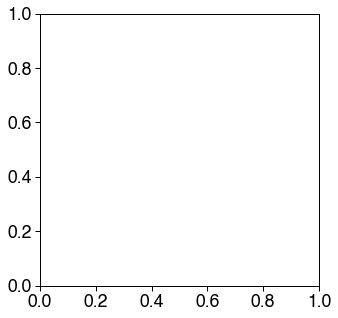

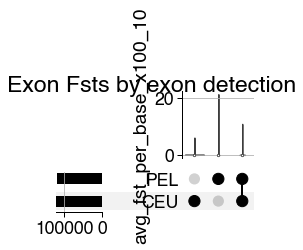

In [70]:
init_plot_settings()
upset = upsetplot.UpSet(temp, intersection_plot_elements=0)  # disable the default bar chart
upset.add_catplot(
    kind='violin',
    value='avg_fst_per_base_x100_10')
ax = plt.gca()
upset.plot()
plt.suptitle('Exon Fsts by exon detection')
# plt.savefig('td_personal_perc_novel_pers_spec_sjs.pdf', dpi=500)

In [71]:
temp.reset_index(inplace=True)
temp['med_per_group'] = temp.groupby([pop1, pop2])['avg_fst_per_base_x100_10'].transform('median')
temp['mean_per_group'] = temp.groupby([pop1, pop2])['avg_fst_per_base_x100_10'].transform('mean')

temp[[pop1, pop2, 'med_per_group']].drop_duplicates()
temp[[pop1, pop2, 'mean_per_group']].drop_duplicates()

,CEU,PEL,mean_per_group
0,False,True,0.016942
2,True,True,0.012500
8,True,False,0.015274


In [72]:
temp['thing'] = ''
temp.loc[(temp[pop1]==True)&(temp[pop2]==True), 'thing'] = f'{pop1}_{pop2}'
temp.loc[(temp[pop1]==True)&(temp[pop2]==False), 'thing'] = f'{pop1}'
temp.loc[(temp[pop1]==False)&(temp[pop2]==True), 'thing'] = f'{pop2}'     
temp.head()

,CEU,PEL,eid,novelty,pop1,pop2,Start,End,End_b,fst_sum,Start_b,elen,avg_fst_per_base_x100,avg_fst_per_base_x100_10,med_per_group,mean_per_group,thing
0,False,True,GL000008.2_+_135133_135173,Known,CEU,PEL,135133,135173,-1,0.0,-1,40,0.0,0.0,0.0,0.016942,PEL
1,False,True,GL000008.2_+_155429_155531,Known,CEU,PEL,155429,155531,-1,0.0,-1,102,0.0,0.0,0.0,0.016942,PEL
2,True,True,GL000008.2_+_83926_84014,Known,CEU,PEL,83926,84014,-1,0.0,-1,88,0.0,0.0,0.0,0.012500,CEU_PEL
3,True,True,GL000008.2_+_83926_84145,Known,CEU,PEL,83926,84145,-1,0.0,-1,219,0.0,0.0,0.0,0.012500,CEU_PEL
4,False,True,GL000008.2_+_85442_85477,Known,CEU,PEL,85442,85477,-1,0.0,-1,35,0.0,0.0,0.0,0.016942,PEL
